# Negative sampling

You may have noticed that word2vec is really slow to train. Especially with big (> 50 000) vocabularies. Negative sampling is the solution.

The task is to implement word2vec with negative sampling. In more detail: you should implement two ways of negative sampling.

## Vanilla negative sampling

This is what was discussed in Stanford lecture. The main idea is in the formula:

$$ L = \log\sigma(u^T_o u_c) + \sum^k_{i=1} \mathbb{E}_{j \sim P(w)}[\log\sigma(-u^T_j, u_c)]$$

Where $\sigma$ - sigmoid function, $u_c$ - central word vector, $u_o$ - context (outside of the window) word vector, $u_j$ - vector or word with index $j$.

The first term calculates the similarity between positive examples (word from one window)

The second term is responsible for negative samples. $k$ is a hyperparameter - the number of negatives to sample.
$\mathbb{E}_{j \sim P(w)}$
means that $j$ is distributed accordingly to unigram distribution, but it is better to use $P^{3/4}(w)$ (empirical results) and you can experiment with some other approaches (for example, try to use uniform distribution).

Thus, it is only required to calculate the similarity between positive samples and some other negatives. Not across all the vocabulary.

Useful links:
1. [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf)
1. [Distributed Representations of Words and Phrases and their Compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)

## Batch-transpose trick for negative sampling

But we can do better. Maybe we don't need to compute vectors for negative samples at all, because we already have a batch of training data and (hopefully) examples in the batch are highly decorrelated.

Let's assume we work with Skip-gram model.

Let $S$ be a batch of _L2-normalized_ word vectors `(batch_size, 2*window_size + 1, word_vector_dim)`.

```python
x = 0.0
for batch_idx in range(batch):
    w = S[batch_idx, :, :]
    x += np.sum(w.T @ w - 1.)

y = 0.0
for window_idx in range(window):
    b = S[:, window_idx, :]
    y += np.sum(b.T @ b)

loss = -x + y```

Think about this loss and compare it to vanilla negative sampling.

Implement word2vec with batch-transpose trick. Modify the formula, if needed.

If you are interested: [more info](https://www.tensorflow.org/extras/candidate_sampling.pdf) on other methods of candidate sampling.

**Results of this task** are the very same as in task 3, **plus**:
 * implement two models (one with vanilla negative sampling and the other with batch-transpose trick)
 * compare all of the models from tasks 3-5. In terms of time and number of iterations until convergence and the quality of the resulting vectors.
 * answer the questions

### Questions:
1. Explain the batch-transpose trick formula in your own words. How would you name x, y, w and b?
1. Should it be modified to serve as a word2vec loss? If yes, how?
1. Is it possible to do the same trick with CBOW model? If yes, how?
1. Does it matter how the batch is made in the case of batch-transpose trick? In the case of vanilla negative sampling?




## Answers:
  1. _
  1. _
  1. _
  1. _

In [1]:
from pathlib import Path
from collections import Counter
from itertools import islice, product, chain
from argparse import Namespace

from tqdm import tqdm_notebook

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tensorboardX import SummaryWriter
from annoy import AnnoyIndex

from sklearn.decomposition import PCA
from MulticoreTSNE import MulticoreTSNE as TSNE
from umap import UMAP
from adjustText import adjust_text

In [2]:
DATA_PATH = Path('../data')
MODELS_PATH = Path('../models')

In [83]:
class SkipGramBatcher():
    def __init__(self, text):
        self.text = text
    
    @classmethod
    def from_file(cls, file_path):
        with open(file_path) as f:
            text = f.read()
        
        return cls(text)
    
    def _tokenize(self):
        self.tokens = self.text.split()
    
    def _count_tokens(self):
        self.token_counts = Counter(self.tokens)
    
    def _build_vocab(self, cutoff):
        self.token_counts = dict(filter(lambda x: x[1] >= cutoff, self.token_counts.items()))
        self.token_to_idx = {token:idx for (idx, (token, _)) 
                             in enumerate(self.token_counts.items())}
        self.idx_to_token = {idx:token for (token, idx) in self.token_to_idx.items()}
        self.vocab = set(self.token_to_idx)
        self.vocab_size = len(self.vocab)

    def _filter_tokens(self):
        self.tokens = [token for token in self.tokens if token in self.vocab]
        self.tokens_size = len(self.tokens)
    
    def _vectorize_tokens(self):
        self.vectorized_tokens = [self.token_to_idx[token] for token in self.tokens]
        
    def _calculate_neg_probs(self, neg_prob_exp):
        token_neg_scores = [(value / self.tokens_size)**neg_prob_exp
                            for key, value in self.token_counts.items()]
        self.token_neg_probs = list(token_neg_scores / np.sum(token_neg_scores))
    
    def _create_sliding_window(self, window_size):
        tokens_size = len(self.tokens)

        for i in range(0, tokens_size):
            center_word = self.vectorized_tokens[i:i+1]
            left_context = self.vectorized_tokens[max(0, i - window_size): i]
            right_context = self.vectorized_tokens[i + 1: min(self.tokens_size, i + window_size + 1)]
            context = left_context + right_context
            window = [list(product(center_word, context))]
            yield window 
    
    def devectorize_tokens(self, indices):
        return [self.idx_to_token[idx] for idx in indices]
        
    def prepare_data(self, cutoff=1, neg_prob_exp=0.75):
        self._tokenize()
        self._count_tokens()
        self._build_vocab(cutoff)
        self._filter_tokens()
        self._vectorize_tokens()
        self._calculate_neg_probs(neg_prob_exp)
        
    def generate_batches(self, window_size=1, batch_size=1, drop_last=True):
        window = self._create_sliding_window(window_size)
        batch = list(zip(*islice(window, batch_size)))
        
        if drop_last:
            while batch and len(batch[0]) == batch_size:
                batch = list(zip(*[pair for pairs in batch[0] for pair in pairs]))
                x_batch, labels_batch = torch.tensor(batch[0]), torch.tensor(batch[1])
                yield x_batch, labels_batch
                batch = list(zip(*islice(window, batch_size)))
        else:
            while batch:
                batch = list(zip(*[pair for pairs in batch[0] for pair in pairs]))
                x_batch, labels_batch = torch.tensor(batch[0]), torch.tensor(batch[1])
                yield x_batch, labels_batch
                batch = list(zip(*islice(window, batch_size)))

In [84]:
sg_batcher = SkipGramBatcher.from_file(DATA_PATH/'text8')
sg_batcher.prepare_data(cutoff=10, neg_prob_exp=0.75)

In [85]:
token_neg_probs = sg_batcher.token_neg_probs
token_neg_probs[:5]

[3.3897566846470835e-05,
 5.459257457856733e-05,
 0.003228941523377695,
 0.006366090944159513,
 0.0003655479357826762]

In [187]:
g = sg_batcher.generate_batches(window_size=1, batch_size=2)
arr = next(g)
arr

(tensor([0, 1, 1]), tensor([1, 0, 2]))

In [185]:
class NaiveWord2VecClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_size, token_neg_probs, k=1):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.token_neg_probs = token_neg_probs
        
#         self.weight_c = nn.Parameter(torch.randn(vocab_size, embedding_size))
#         self.weight_o = nn.Parameter(torch.randn(embedding_size, vocab_size))
        self.emb_c = nn.Embedding(num_embeddings=vocab_size,
                                  embedding_dim=embedding_size)
        self.emb_o = nn.Embedding(num_embeddings=vocab_size,
                                  embedding_dim=embedding_size)
        
    def forward(self, v_c, v_o):
        # (1 x d)
#         x_embedded = self.weight_c[x_in]
        v_c_embedded = self.emb_c(v_c)
        # (k x d)
        neg_samples = self.generate_neg_outputs(k=3, batch_size=v_c.shape[0])
        neg_embedded = self.emb_o(neg_samples)
        v_o_embedded = self.emb_o(v_o)
#         o_embedded = torch.cat([v_o_embedded, neg_embedded], dim=0)
        
        return v_c_embedded, v_o_embedded, neg_samples, neg_embedded#, o_embedded
    
    def generate_neg_outputs(self, batch_size, k=1):
        negative_outputs = np.random.choice(range(self.vocab_size),
                                            size=batch_size * k,
                                            replace=True,
                                            p=self.token_neg_probs).reshape(batch_size, -1)
        negative_outputs = torch.from_numpy(negative_outputs)
        return negative_outputs

In [186]:
arr

(tensor([0, 1, 1]), tensor([1, 0, 2]))

In [169]:
clf = NaiveWord2VecClassifier(sg_batcher.vocab_size, 2, token_neg_probs)
res = clf(arr[0], arr[1])
res

(tensor([[-1.4100, -1.4974],
         [ 1.2116, -1.8269],
         [ 1.2116, -1.8269]], grad_fn=<EmbeddingBackward>),
 tensor([[-0.4380,  0.1938],
         [ 0.2529, -0.9034],
         [ 0.6692, -0.6682]], grad_fn=<EmbeddingBackward>),
 tensor([[13407, 34047,   683],
         [43137,   779,  5082],
         [ 3501,  4433, 19259]]),
 tensor([[[ 0.5742, -1.4690],
          [-0.3603, -0.5749],
          [ 1.4960,  0.9767]],
 
         [[ 0.9171,  1.2679],
          [-0.2828, -0.3097],
          [ 0.8333,  0.2855]],
 
         [[-0.8574, -0.4804],
          [-0.4560,  0.5374],
          [-0.2353,  1.5769]]], grad_fn=<EmbeddingBackward>))

In [171]:
v_c, v_o, _, neg = res
print(v_c.shape, v_o.shape, neg.shape)
v_c, v_o, neg

torch.Size([3, 2]) torch.Size([3, 2]) torch.Size([3, 3, 2])


(tensor([[-1.4100, -1.4974],
         [ 1.2116, -1.8269],
         [ 1.2116, -1.8269]], grad_fn=<EmbeddingBackward>),
 tensor([[-0.4380,  0.1938],
         [ 0.2529, -0.9034],
         [ 0.6692, -0.6682]], grad_fn=<EmbeddingBackward>),
 tensor([[[ 0.5742, -1.4690],
          [-0.3603, -0.5749],
          [ 1.4960,  0.9767]],
 
         [[ 0.9171,  1.2679],
          [-0.2828, -0.3097],
          [ 0.8333,  0.2855]],
 
         [[-0.8574, -0.4804],
          [-0.4560,  0.5374],
          [-0.2353,  1.5769]]], grad_fn=<EmbeddingBackward>))

In [184]:
v_c.unsqueeze(0).shape, neg.shape, torch.transpose(neg, 2, 1).shape

(torch.Size([1, 3, 2]), torch.Size([3, 3, 2]), torch.Size([3, 2, 3]))

In [182]:
torch.bmm(v_c.unsqueeze(0), torch.transpose(neg, 2, 1))

RuntimeError: Expected tensor to have size 1 at dimension 0, but got size 3 for argument #2 'batch2' (while checking arguments for bmm)

In [63]:
g = sg_batcher.generate_batches(window_size=3,
                                batch_size=1024)

In [42]:
for _ in tqdm_notebook(range(100)):
    np.random.choice(range(sg_batcher.vocab_size),
                        size = 1024 * 3,
                        replace=True,
                        p = sg_batcher.token_neg_probs).reshape(1024, -1)

In [47]:
for _ in tqdm_notebook(range(100)):
    sg_batcher._generate_negative_outputs(k=3, size=256)

In [26]:
np.random.choice(range(len(sg_batcher.vocab)), size=12, replace=True, p=sg_batcher.token_neg_probs).reshape(3, -1)

array([[ 1639, 10077,  6125,  2075],
       [ 3150,  4959, 29402,   305],
       [ 1563, 12646, 38240, 25660]])

In [213]:
batch = [(0, (1, [340, 34997, 15])), (0, (2, [248, 11726, 1903])), (0, (3, [13380, 45263, 4490]))]
batch

[(0, (1, [340, 34997, 15])),
 (0, (2, [248, 11726, 1903])),
 (0, (3, [13380, 45263, 4490]))]

In [216]:
list(zip(*batch))[1]

((1, [340, 34997, 15]), (2, [248, 11726, 1903]), (3, [13380, 45263, 4490]))

In [142]:
center = [0, 0, 0]
context = [[(0, (1, [23790, 4499, 165])),
          (0, (2, [4135, 20707, 13853])),
          (0, (3, [4306, 3837, 243]))]]

In [144]:
list(zip(center, context))

[(0, (1, [14550, 17844, 19042])),
 (0, (2, [5141, 33485, 21678])),
 (0, (3, [3263, 675, 33346]))]

In [168]:
batch = [(0, (1, [4508, 267, 1695])), (0, (2, [4084, 344, 27567])), (0, (3, [6347, 327, 10095]))]
batch

[(0, (1, [4508, 267, 1695])),
 (0, (2, [4084, 344, 27567])),
 (0, (3, [6347, 327, 10095]))]

In [170]:
list(zip(batch))

TypeError: list() takes at most 1 argument (3 given)

In [ ]:
sg_batcher.token_neg_probs[:3]

In [ ]:
neg_g = sg_batcher._get_negative_outputs(k=3, size=3)
neg_g

In [117]:
list(chain.from_iterable(zip([1, 2, 3], neg_g)))

[1, [1801, 579, 25424], 2, [4366, 32120, 381], 3, [8384, 21399, 5617]]

In [98]:
t = torch.multinomial(torch.tensor(token_neg_probs), 
                        12, replacement=False).view(3, -1)
t

tensor([[  506, 20011,  2034,   823],
        [14741, 20081, 18746, 41748],
        [24784,    15, 26064,  4076]])

In [105]:
t.numpy().tolist()

[[506, 20011, 2034, 823],
 [14741, 20081, 18746, 41748],
 [24784, 15, 26064, 4076]]

In [109]:
args = Namespace(
    file_path = DATA_PATH/'text8',
    model_state_path = MODELS_PATH/'naive_word2vec_embeddings.pth',
    weights_path = MODELS_PATH/'weights.npz',
    
    embedding_size = 100,
    
    seed = 42,
    cutoff = 10,
    window_size = 3,
    stride = 1,
    batch_size = 1024,
    learning_rate = 0.03,
    iterations = 1000,
    save_iterations = 100,
    early_stopping_criteria = 1e8,
    factor=0.5,
    patience=5000,
    neg_prob_degree=0.75
    
    cuda=True
)

In [284]:
g = sg_batcher._create_sliding_window(2)
next(g)

[[(0, 1), (0, 2)]]

In [36]:
tokens_size = len(sg_batcher.tokens)
tokens_size

16561031

In [77]:
token_neg_scores = np.array([(value/sg_batcher.tokens_size)**0.75
                            for key, value in sg_batcher.token_counts.items()])
token_neg_scores[:10]

array([0.00027975, 0.00045054, 0.0266476 , 0.05253766, 0.00301677,
       0.08238481, 0.00044521, 0.00851808, 0.00713238, 0.00338947])

In [38]:
token_neg_scores_sum = np.sum(token_neg_scores)
token_neg_scores_sum

8.252735343222646

In [39]:
token_neg_probs = token_neg_scores / token_neg_scores_sum
token_neg_probs

array([3.38975668e-05, 5.45925746e-05, 3.22894152e-03, ...,
       2.62474160e-06, 3.90771827e-06, 2.62474160e-06])

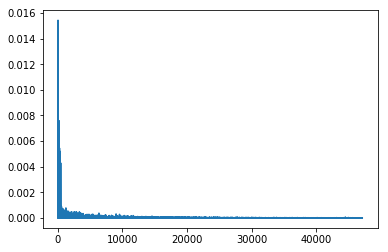

In [94]:
plt.plot(token_neg_probs)

In [316]:
k = 5
batch_size = 3
arr = token_neg_probs # [1, 5, 6, 10]

x_numpy = np.array(arr) / np.sum(arr)
x_torch = torch.tensor(x_numpy, dtype=torch.float32)
x_torch, x_numpy

(tensor([3.3898e-05, 5.4593e-05, 3.2289e-03,  ..., 2.6247e-06, 3.9077e-06,
         2.6247e-06]),
 array([3.38975668e-05, 5.45925746e-05, 3.22894152e-03, ...,
        2.62474160e-06, 3.90771827e-06, 2.62474160e-06]))

In [317]:
sample_torch = torch.multinomial(x_torch, k, replacement=True) #.view(batch_size, -1)
print(np.bincount(sample_torch) / np.bincount(sample_torch).sum())
sample_torch

[0.  0.  0.  ... 0.  0.  0.2]


tensor([   15, 25967,  1177,  5236, 23144])

In [273]:
sample_numpy = np.random.multinomial(1, x_numpy, size=k).nonzero()[1]
print(np.bincount(sample_numpy) / np.bincount(sample_numpy).sum())
sample_numpy

[0.  0.  0.2 0.8]


array([2, 3, 3, 3, 3])